In [1]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from images import get_images_eval, create_batch, images_train, images_valid, BATCH_SIZE
from tensorflow.keras import layers, models, optimizers
import numpy as np

resnet_triplet_net_dir = './result/resnet_imagenet/resnet_triplets-norm-no-dec'

images_eval = get_images_eval()
input_shape = images_eval.shape[1:]
# input = layers.Input(input_shape)
resnet_base = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
decoder = models.Sequential(name='decoder')
decoder.add(layers.Flatten())
# decoder.add(layers.Dense(512, activation='relu'))
# decoder.add(layers.Dense(1024, activation='relu'))
# decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
# decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))
resnet_embedding = Model(inputs=resnet_base.inputs, outputs=decoder(resnet_base.output), name='ResNet50')
resnet_embedding.summary(), #resnet_embedding.layers #, decoder.summary()
# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True, layer_range=["input_7", "conv2_block1_out"])
# from tensorflow.keras import optimizers

# tf.keras.utils.plot_model(resnet_embedding, to_file="model.png", show_shapes=True)
# predict_and_print(resnet_embedding, images_eval, "images_eval_resnet")

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


c:\Users\Tautvydas\Documents\magistras\master_capsnet\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0-rc2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

(None,)

In [2]:
input_a = layers.Input(name="anchor", shape=images_eval.shape[1:])
input_p = layers.Input(name="positive", shape=images_eval.shape[1:])
input_n = layers.Input(name="negative", shape=images_eval.shape[1:])

embedding_a = resnet_embedding(input_a)
embedding_p = resnet_embedding(input_p)
embedding_n = resnet_embedding(input_n)

output = layers.concatenate([embedding_a, embedding_p, embedding_n], axis=1)
# print(output)

siamese_net = models.Model([input_a, input_p, input_n], output)
siamese_net.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ResNet50 (Functional)           (None, 2048)         23587712    anchor[0][0]                     
                                                                 positive[0][0]               

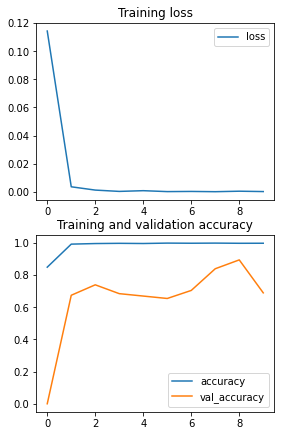

In [3]:
import tensorflow as tf
from metrics import get_callbacks
from utils.utils import plot_log

emb_size = 2048
alpha = 0.2
def triplet_loss(y_true, y_pred):
    # tf.print(y_pred, y_pred.shape)
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:, emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    L = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    return L


def accuracy(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:, emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return positive_dist + alpha < negative_dist

def data_generator(images):
    while True:
        x = create_batch(images, (32, 32, 3))
        y = np.zeros((100, 3*emb_size))
        yield [x[0], x[1], x[2]], y

# data_generator().send(None)[0][0].shape

lr = 0.0001
optimiser_obj = optimizers.Adam(learning_rate=lr)
siamese_net.compile(loss=triplet_loss, optimizer=optimiser_obj, metrics=[accuracy])

net_callbacks = get_callbacks(resnet_triplet_net_dir, lr, 0.9, 'val_accuracy')
weights_file = resnet_triplet_net_dir + '/trained_model.h5'
run_fit = False
if(run_fit):
    siamese_net.fit(
        data_generator(images_train),
        steps_per_epoch=int(len(images_train)/BATCH_SIZE), 
        epochs=10, 
        validation_data=data_generator(images_valid),
        validation_steps=int(len(images_valid)/BATCH_SIZE),
        callbacks=[net_callbacks])
    siamese_net.save_weights(weights_file)
    print('Trained model saved to \'%s\'' % weights_file)
else:
    siamese_net.load_weights(weights_file)

plot_log(resnet_triplet_net_dir + '/log.csv', show=True)

In [4]:
from images import get_images_eval, predict_and_print, create_batch, images_train, images_valid, images_test, preprocess_image_with_angle

shape = images_eval.shape[1:]
x_a = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
x_p = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
x_n = np.zeros((BATCH_SIZE*10, *shape))  # * - expands tuple
for i in range(10):
    for j in range(10):
        for angle in range(10):
            image_a = preprocess_image_with_angle(
                images_test[i*3], angle, 10)
            image_p = preprocess_image_with_angle(
                images_test[i*3+1], 0, 10)
            image_n = preprocess_image_with_angle(
                images_test[j*3+2], 0, 10)
            x_a[i*100 + j*10 + angle] = image_a
            x_p[i*100 + j*10 + angle] = image_p
            x_n[i*100 + j*10 + angle] = image_n
images_test_eval = np.array([x_a, x_p, x_n])
images_test_eval.shape, len(images_test)

((3, 1000, 32, 32, 3), 30)

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from utils.utils import combine_images
file_name = "triplet_recon"
x_recon = siamese_net.predict([x_a, x_p, x_n], batch_size=100)

accuracy 97.0 97 3


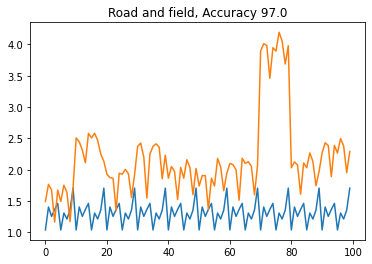

accuracy 49.0 49 51


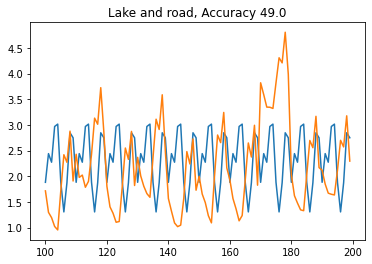

accuracy 95.0 95 5


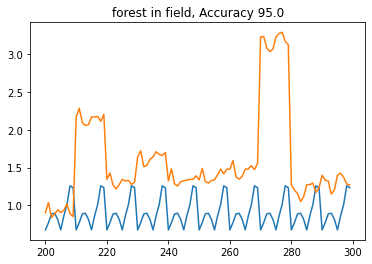

accuracy 50.0 50 50


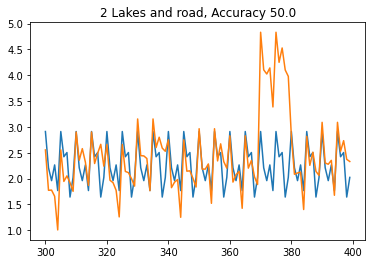

accuracy 54.0 54 46


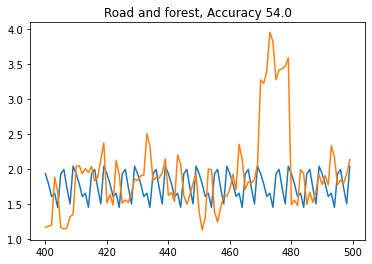

accuracy 68.0 68 32


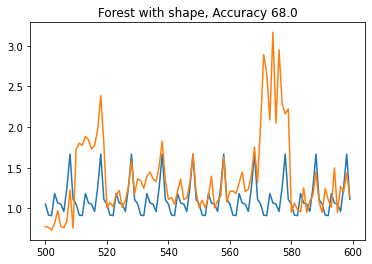

accuracy 84.0 84 16


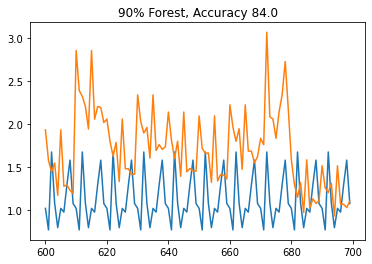

accuracy 97.0 97 3


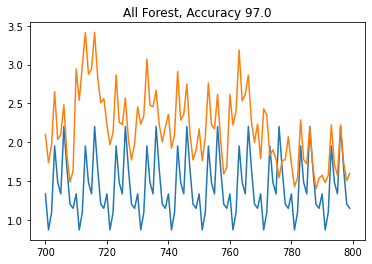

accuracy 58.0 58 42


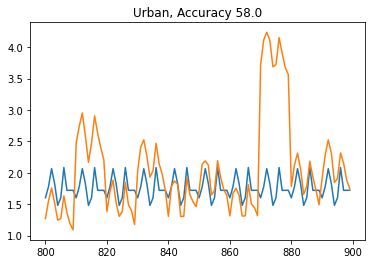

accuracy 84.0 84 16


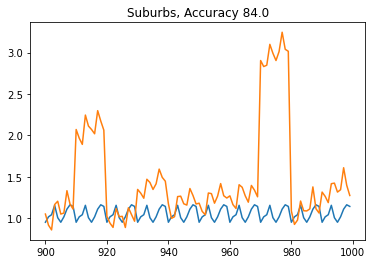

In [6]:


def show_graph(_range, title):
    tp = 0
    fp = 0
    xaxis = []
    yaxis = []
    for i in _range:
        embedding_img_a = x_recon[i, :emb_size]
        embedding_img_p = x_recon[i, emb_size:2*emb_size]
        embedding_img_n = x_recon[i, 2*emb_size:]
        # embedding_img_a.shape, embedding_img_p.shape, embedding_img_n.shape
        p = np.mean(np.square(embedding_img_a - embedding_img_p))
        n = np.mean(np.square(embedding_img_a - embedding_img_n))
        # print(p, n)
        pda = np.nansum(p)
        nda = np.nansum(n)
        # print(pda, nda)
        xaxis.append(i)
        yaxis.append([pda, nda])
        # print(pda, nda)
        if pda < nda:
            tp += 1
        else:
            fp +=1 
        # print(np.max(p), np.max(n), np.max(p - n), np.max(p - n + 0.2), p < n)
    print('accuracy', np.round(tp / (tp + fp) * 100, 1), tp, fp)
    plt.plot(xaxis, yaxis)
    plt.title(title + ', Accuracy ' + str(np.round(tp / (tp + fp) * 100, 1)))
    plt.show()

show_graph(range(0, 100), 'Road and field')
show_graph(range(100, 200), 'Lake and road')
show_graph(range(200, 300), 'forest in field')
show_graph(range(300, 400), '2 Lakes and road')
show_graph(range(400, 500), 'Road and forest')
show_graph(range(500, 600), 'Forest with shape')
show_graph(range(600, 700), '90% Forest')
show_graph(range(700, 800), 'All Forest')
show_graph(range(800, 900), 'Urban')
show_graph(range(900, 1000), 'Suburbs')